In [359]:
import numpy as np
import copy, time, random

In [347]:
import matplotlib.pyplot as plt

## analyzing the cracker barrel peg game

Maybe my favorite thing about cracker barrel is the [peg game](https://www.cs.virginia.edu/cs201j/problem-sets/ps4/cbfront.jpg) they put at every table. The challenge is to eliminate the pegs on the board by jumping over an adjacent peg into an empty spot, checkers style, leaving only one peg, and proving that you are, in fact, a genius.

I was wondering though, how many ways can you solve this game? Is every solution equally likely? Are there any interesting patterns? Below is my best attempt as illuminating these important questions.



In [480]:
# represents a coordinate on the board by row,column
class pos:
    def __init__(self, r, c):
        self.row = r
        self.col = c
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return (self.row == other.row) and (self.col == other.col)
        else:
            return False
        
    def __hash__(self):
        return hash((self.row,self.col))
    def __str__(self):
        return f'({self.row},{self.col})'
    def __repr__(self):
        return f'({self.row},{self.col})'

In [481]:
# Represents a game board of any number of rows (at cracker barrel - 5)
# game board is a triangular list of lists - [[1],[2,3],[4,5,6]...]
# Implements useful methods for running simulations - an all_spots() generator, jump(), neighbors(), etc.
class board:
    def __init__(self, rows):
        self.board = []
        for i in range(rows):
            self.board.append([1]*(i+1))
        self.board[0][0] = 0
        self.max_moves = len(self.flatten())-2
        self.win_count = 0
        
        # dict of (initial empty position : (dict of (final peg position) : count of paths to that final peg given the starting pos)
        self.init_to_final_cts = {} 
        
    def __str__(self):
        s = ''
        for row in self.board:
            s += str(row) + '\n'
        return s
    
    # generator, yields all positions on the board from top to bottom, left to right
    def all_spots(self):
        for r in range(len(self.board)):
            for c in range(r+1):
                yield pos(r,c)
    
    # returns tuple of the board, flattened to a 1d array
    def flatten(self):
        return tuple([self.board[p.row][p.col] for p in self.all_spots()])
    
    # resets the board with full pegs, and an empty spot at the given pos
    def start(self, init_pos):
        for p in self.all_spots():
            self.board[p.row][p.col] = 1
        self.board[init_pos.row][init_pos.col] = 0
    
    # gets position of spot from jumping a over b
    def get_over_pos(self, a, b):
        c = pos(None,None)
        c.row = a.row if a.row == b.row else (b.row+1 if b.row > a.row else b.row-1)
        if c.row < 0 or c.row >= len(self.board):
            return None
        # 3 cases: same row,  a above b, a below b
        if a.row == b.row:
            c.col = b.col+1 if b.col > a.col else b.col - 1
        elif a.row < b.row:
            if a.col == b.col:
                c.col = b.col
            elif b.col == a.col+1:
                c.col = b.col+1
            else:
                return None
        elif a.row > b.row:
            if a.col == b.col:
                c.col = b.col
            elif b.col == a.col-1:
                c.col = b.col-1
            else:
                return None
        if c.col < 0 or c.col > c.row:
            return None
        return c
        
    # jumps piece at a over piece at b, removing piece at b. returns new position of piece a
    def jump(self, a, b):
        c = self.get_over_pos(a,b)
        if c == None:
            return None
        elif self.board[c.row][c.col] != 0 or self.board[a.row][a.col] != 1 or self.board[b.row][b.col] != 1:
            return None
        else:
            # new_b = copy.deepcopy(self) #slow slow slow!!!
            self.board[c.row][c.col] = 1
            self.board[a.row][a.col] = 0
            self.board[b.row][b.col] = 0
            return c
    
    # undoes a jump
    def unjump(self, a, b, c):
        self.board[c.row][c.col] = 0
        self.board[a.row][a.col] = 1
        self.board[b.row][b.col] = 1
        
    # checks that a jump won't send piece out of bounds, and that the pieces do exist at the needed pos's
    def can_jump(self, a, b):
        c = self.get_over_pos(a,b)
        if c == None:
            return False
        elif self.board[c.row][c.col] != 0 or self.board[a.row][a.col] != 1 or self.board[b.row][b.col] != 1:
            return False
        else:
            return True
    
    # returns all neighbors of piece that it can jump over 
    def neighbors(self, a):
        nbrs = [pos(a.row, a.col-1),pos(a.row, a.col+1),pos(a.row-1, a.col),
                pos(a.row-1, a.col-1),pos(a.row+1, a.col),pos(a.row+1, a.col+1)]
        return list(n for n in nbrs if self.can_jump(a,n))
    
    # win if there is exactly one piece
    def is_solved(self):
        return sum(self.flatten()) == 1
        
            

In [483]:
# Given a number of moves d, sets up a game board already at each winning position, and simulates all possible chains of
# *reverse moves* up to length d. (a reverse move is just doing an unjump()). that is, this class generates all game states 
# that are d moves from a winning state. once it finds any of these states, it adds/updates a dict counting the number of chains
# that generated a given d-moves-to-win state.
# then, a forward search from a starting position needs only to search 13-d moves forward, then check if the state it 
# reached is one that can reach a winning position (and it will immediately also have the *number* of paths to a winning state)
class reverse_stats(board):
    def __init__(self, rows, d):
        super().__init__(rows)
        self.clear()
            
        # keys - flat states that are depth moves from a solve state, 
        # vals - the count of paths to a solve state
        self.reverse_state_ct = {} 
        
        # key - same states as above
        # val - dict of various final positions : count. needed to carry that information up to board class
        self.reverse_finaltoct = {}
        self.max_depth = d
        
    def clear(self):
        for p in self.all_spots():
            self.board[p.row][p.col] = 0
            
            
    def not_oob(self, p):
        if p.row < 0 or p.col < 0:
            return False
        if p.row >= len(self.board) or p.col > p.row:
            return False
        return True
    
    def can_unjump(self, c, a, b):
        if self.not_oob(c) and self.not_oob(a) and self.not_oob(b):
            if self.board[c.row][c.col] == 1 and self.board[a.row][a.col] == 0 and self.board[b.row][b.col] == 0:
                return True
        return False
    
    def all_unjumps(self):
        for p in self.all_spots():
            for jump in [(p, pos(p.row, p.col-1), pos(p.row, p.col-2)),
                        (p, pos(p.row, p.col+1), pos(p.row, p.col+2)),
                        (p, pos(p.row-1, p.col), pos(p.row-2, p.col)),
                        (p, pos(p.row-1, p.col-1), pos(p.row-2, p.col-2)),
                        (p, pos(p.row+1, p.col), pos(p.row+2, p.col)),
                        (p, pos(p.row+1, p.col+1), pos(p.row+2, p.col+2))]:
                if self.can_unjump(jump[0],jump[1],jump[2]):
                    yield jump
    
    # begins recursive DFS from all positions that leave just one piece
    def fill_allnormalwins(self):
        for p in self.all_spots():
            self.board[p.row][p.col] = 1
            self.fill_reverse(0, p)
            self.clear()
            
    # recursive DFS that terminates at the given depth and updates the state dict with each state 
    # takes all possible unjumps()
    def fill_reverse(self, depth, finalpos):
        if depth == self.max_depth:
            flat = self.flatten()
            if flat in self.reverse_state_ct:
                self.reverse_state_ct[flat] += 1
            else:
                self.reverse_state_ct[flat] = 1
                self.reverse_finaltoct[flat] = {}
                
            if finalpos in self.reverse_finaltoct[flat]:
                self.reverse_finaltoct[flat][finalpos] += 1
            else:
                self.reverse_finaltoct[flat][finalpos] = 1
                
            return
        
        for jump in self.all_unjumps():
            self.unjump(jump[2],jump[1],jump[0]) # confusing order, I know. but it's after midnight
            self.fill_reverse(depth+1, finalpos)
            self.jump(jump[2],jump[1])
            
        
        

In [484]:
rs = reverse_stats(5, 7) 
t = time.time()
rs.fill_allnormalwins() # generates all states on the 5-board that are 7 moves from a win
print("generated all reverse paths", time.time()-t, "sec.")

generated all reverse paths 28.123485565185547 sec.


In [485]:
# the number of games that are 7 moves from a win is...
len(rs.reverse_state_ct)

2964

In [486]:
# starts a forward search from all starting positions
def forward_search_all(board):
    for p in board.all_spots():
        board.start(p)
        forward_search(board, 0, p)

# recursive DFS to a depth of max_moves minus the reverse_stats depth. once this depth is reached, the state is checked
# on the reverse_stats dict to see if it can lead to a win, and if so, increases the internal win_count by that number of paths
def forward_search(board, depth, init_pos):
    if depth == board.max_moves - rs.max_depth:
        f = board.flatten()
        if f in rs.reverse_state_ct:
            board.win_count += rs.reverse_state_ct[f]
            for final in rs.reverse_finaltoct[f]:
                if init_pos not in board.init_to_final_cts:
                    board.init_to_final_cts[init_pos] = {}
                if final in board.init_to_final_cts[init_pos]:
                    board.init_to_final_cts[init_pos][final] += rs.reverse_finaltoct[f][final]
                else:
                    board.init_to_final_cts[init_pos][final] = rs.reverse_finaltoct[f][final]
        return
    with_nbrs = [(a, board.neighbors(a)) for a in board.all_spots() if len(board.neighbors(a)) > 0]
    for p in with_nbrs:
        for b in p[1]:
            c = board.jump(p[0],b)
            forward_search(board, depth+1, init_pos)
            board.unjump(p[0],b,c)


In [487]:
b = board(5)
t=time.time()
forward_search_all(b) # simulates all 6-move games and updates win_count if state can lead to a win
print("found all forward states in", time.time()-t, "sec")

found all forward states in 7.845417737960815 sec


In [488]:
# total number of ways to win the game
b.win_count

438984

In [489]:
# table of initial start location and final peg location with counts of paths between them
b.init_to_final_cts

{(0,0): {(0,0): 6816, (3,0): 3408, (4,2): 16128, (3,3): 3408},
 (1,0): {(2,2): 8064, (4,0): 3408, (4,3): 2688, (1,0): 720},
 (1,1): {(2,0): 8064, (1,1): 720, (4,1): 2688, (4,4): 3408},
 (2,0): {(2,0): 51452, (4,1): 8064, (4,4): 16128, (1,1): 8064, (3,2): 1550},
 (2,1): {(4,2): 1550},
 (2,2): {(2,2): 51452, (4,0): 16128, (4,3): 8064, (1,0): 8064, (3,1): 1550},
 (3,0): {(0,0): 3408, (3,0): 720, (4,2): 8064, (3,3): 2688},
 (3,1): {(2,2): 1550},
 (3,2): {(2,0): 1550},
 (3,3): {(0,0): 3408, (3,0): 2688, (4,2): 8064, (3,3): 720},
 (4,0): {(2,2): 16128, (4,0): 6816, (4,3): 3408, (1,0): 3408},
 (4,1): {(2,0): 8064, (1,1): 2688, (4,1): 720, (4,4): 3408},
 (4,2): {(0,0): 16128, (3,0): 8064, (4,2): 51452, (3,3): 8064, (2,1): 1550},
 (4,3): {(2,2): 8064, (1,0): 2688, (4,0): 3408, (4,3): 720},
 (4,4): {(2,0): 16128, (1,1): 3408, (4,1): 3408, (4,4): 6816}}

It's interesting that for any starting position, there's a specific subset of locations that are possible to end the game on

In [490]:
inits_to_percent = {k:0 for k in b.init_to_final_cts}
for i in inits_to_percent:
    for f in b.init_to_final_cts[i]:
        inits_to_percent[i]+=(b.init_to_final_cts[i][f]/(b.win_count/100))
        
# starting location to percentage of possible wins reachable from there 
inits_to_percent

{(0,0): 6.779290361379913,
 (1,0): 3.3896451806899566,
 (1,1): 3.389645180689956,
 (2,0): 19.421664570918303,
 (2,1): 0.3530880396552038,
 (2,2): 19.421664570918303,
 (3,0): 3.3896451806899566,
 (3,1): 0.3530880396552038,
 (3,2): 0.3530880396552038,
 (3,3): 3.3896451806899566,
 (4,0): 6.779290361379914,
 (4,1): 3.389645180689956,
 (4,2): 19.421664570918303,
 (4,3): 3.3896451806899566,
 (4,4): 6.779290361379914}

Here we can see the largest proportion of possible wins begin with the peice in one of the side middle positions: (2,0), (2,2), or (4,2) - each of which lead to wins that represent 19.4% of all possible wins.

In [491]:
# using pyplot to visually represent at some of this data
def show_state(board):
    circles = []
    for i in range(len(board)):
        for j in range(i+1):
            circle = plt.Circle((5+(j*1.6)-(i*0.75), 8-(i*1.5)), 0.4, color=(0,0,0,1), fill=(board[i][j]==1))
            circles.append(circle)


    fig, ax = plt.subplots()
    ax.set_xlim((0, 10))
    ax.set_ylim((0, 10))
    plt.gca().set_aspect('equal')
    for circle in circles:
        ax.add_patch(circle)

def show_flat(flattened):
    brd = board(5)
    i = 0
    for r in range(5):
        for c in range(r+1):
            brd.board[r][c] = flattened[i]
            i += 1
    show_state(brd.board)

def starttofinal_heatmap(pos_to_ct_dict, start_pos=False):
    total = sum(list(pos_to_ct_dict.values()))
    circles = []
    for i in range(5):
        for j in range(i+1):
            if pos(i,j) in pos_to_ct_dict:
                circle = plt.Circle((5+(j*1.6)-(i*0.75), 8-(i*1.5)), 0.4, 
                                color=(1,0,0,(pos_to_ct_dict[pos(i,j)]/total)), 
                                fill=True)
                circles.append(circle)
            else:
                circle = plt.Circle((5+(j*1.6)-(i*0.75), 8-(i*1.5)), 0.4, 
                                color=(.2,.2,.2), 
                                fill=False)
                circles.append(circle)
            if start_pos != False and start_pos.row == i and start_pos.col == j: # add extra green ring to show start position
                circle = plt.Circle((5+(j*1.6)-(i*0.75), 8-(i*1.5)), 0.4, 
                                color=(0,1,0,1), fill=False)
                circles.append(circle)

    fig, ax = plt.subplots()
    ax.set_xlim((0, 10))
    ax.set_ylim((0, 10))
    plt.gca().set_aspect('equal')
    for circle in circles:
        ax.add_patch(circle)
    

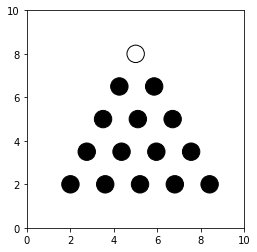

In [492]:
# the starting board
show_state(board(5).board)

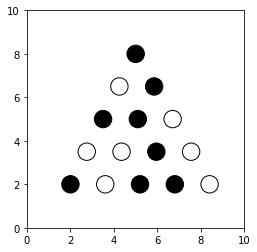

In [493]:
# a random board that is 7 moves from a win
show_flat(random.choice(list(rs.reverse_state_ct.keys())))

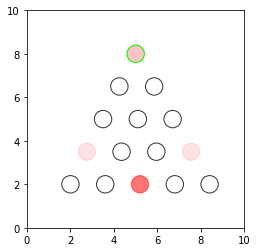

In [494]:
# starting position in green, and all possible ending positions in red, where more intense == larger proportion 
# of games ending at that spot
init_pos = pos(0,0)
starttofinal_heatmap(b.init_to_final_cts[init_pos], start_pos=init_pos)

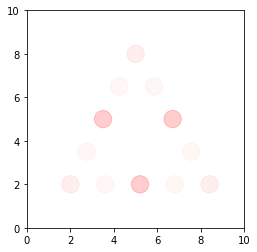

In [495]:
# marginal sum of ending position counts
final_totals = {}
for i in b.init_to_final_cts:
    for f in b.init_to_final_cts[i]:
        if f in final_totals:
            final_totals[f] += b.init_to_final_cts[i][f]
        else:
            final_totals[f] = b.init_to_final_cts[i][f]
starttofinal_heatmap(final_totals)
# we can see the side middle spots are also the most common ending spots,
# and that the center spots are exceedingly rare ones to end on.

That's as far as I've investigated for now. My key takeaways from this- 

1: bidirectional search is the most computationally efficient way to search this problem - since the search tree from either side gets very wide, and have many many paths that *almost* reach a solution, it's very inefficient to enumerate all of these. Reducing the forward search problem to a much lower depth by searching backwards from all the solution states to a certain depth was extremely key - it was an order of magnitude speedup compared to my 2nd idea below.

2: I'm surprised by the results - especially that it's not a uniform distrobution of solution states. In the future I'd like to see what the heatmap above looks like when you scale up the size of the board. Though, I have a feeling that searching for something like n=100 I'd need to switch to a more stochastic method.

That's all for now, thanks for reading!

Jeremiah Crowell

---
Everything below here is failed attempts, just keeping for the sake of it.

This was actually my second idea - just operate on the single board, recursively make all moves possible, and at each step, update a dict of (board state)->(count of paths to it) in the board class, resulting in a full count of all states. Then, I could look up each possible end state and read off the count from the dict. This computed all of the states from one starting position in 265 seconds. 
I thought this was my first success, and it was interesting to see that there are only 4 reachable end states from the starting position I looked at.

It was around this time that I looked online to see if others had worked on this problem. The author of [this blog](https://grover.news/2016/03/15/cracker-barrel-conundrum/) analyzed it for all starting positions, and various other win conditions other that "just leave 1" - so I figured I could do better. Credit to anitasv for commenting their implementation of a two-sided search which helped me greatly.

In [497]:
# recursively takes moves and fills in board's state counts
def search(board):
    state = tuple(board.flatten()) # whatever state we're at, increase the amount of paths that reach it by 1
    if state in board.state_count:
        board.state_count[state] += 1
    else:
        board.state_count[state] = 1
    
    # then find all possible moves, and recurse into them.
    with_nbrs = [(a, board.neighbors(a)) for a in board.all_spots() if len(board.neighbors(a)) > 0]
    for p in with_nbrs:
        for b in p[1]:
            c = board.jump(p[0],b)
            search(board)
            board.unjump(p[0],b,c)
            
b = board(5)

t = time.time()
search(b)
print("done in", time.time()-t) 
# done in 265.4284505844116

AttributeError: 'board' object has no attribute 'state_count'

In [152]:
bex = board(5)
for p in bex.all_spots():
    bex.board[p.row][p.col] = 0
for p in bex.all_spots():
    bex.board[p.row][p.col] = 1
    f = tuple(bex.flatten())
    print(f, b.state_count[f] if f in b.state_count else 0)
    bex.board[p.row][p.col] = 0


(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 6816
(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0) 3408
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0) 3408
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0) 0
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0) 0
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0) 16128
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0) 0
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1) 0


```
(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 6816
(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0) 3408
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0) 0
(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0) 3408
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0) 0
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0) 0
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0) 16128
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0) 0
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1) 0
```

---
The following is the work from my first attempt. Originally I thought of a search state being a unique board object/move list pair. Each call to .jump() would copy and return the new board state. 
DFS with this model returned the first solution it found in about 20 seconds. BFS only reached a depth of 7 moves in 5 minutes. Copying the entire board every move is way too slow to analyze all the game states quickly.

In [61]:
# state in the search space
# copying board for each state searched is slowwww
class state:
    def __init__(self, b, m):
        self.board = b # board state
        self.moves = m # moves leading to state, list of tuples of positions in form of (moved, over)
    

In [62]:
# finds *A* solution in about 20 seconds. 
def dfs_search(b):
    start = state(b, [])
    frontier = [start]
    while True:
        if len(frontier) == 0:
            return None
        curr = frontier.pop()
        if curr.board.is_solved():
            return curr
        brd = curr.board.board
        with_nbrs = []
        for row in range(len(brd)):
            for col in range(len(brd[row])):
                a = pos(row, col)
                a_nbrs = curr.board.neighbors(a)
                if len(a_nbrs) > 0:
                    with_nbrs.append((a,a_nbrs))
        for p in with_nbrs:
            for b in p[1]:
                next_board = curr.board.jump(p[0],b)
                next_moves = copy.deepcopy(curr.moves)
                next_moves.append((p[0],b))
                frontier.append(state(next_board, next_moves))

In [63]:
# didn't finish in 10 minutes
def dfs_search_all(b):
    start = state(b, [])
    frontier = [start]
    solns = []
    while True:
        if len(frontier) == 0:
            return solns
        curr = frontier.pop()
        if curr.board.is_solved():
            solns.append(curr)
        brd = curr.board.board
        with_nbrs = []
        for row in range(len(brd)):
            for col in range(len(brd[row])):
                a = pos(row, col)
                a_nbrs = curr.board.neighbors(a)
                if len(a_nbrs) > 0:
                    with_nbrs.append((a,a_nbrs))
        for p in with_nbrs:
            for b in p[1]:
                next_board = curr.board.jump(p[0],b)
                next_moves = copy.deepcopy(curr.moves)
                next_moves.append((p[0],b))
                frontier.append(state(next_board, next_moves))

In [54]:
# only gets to depth 7 after 5 minutes
def bfs_search(b):
    start = state(b, [])
    frontier = [start]
    depth = 0
    dt = time.time()
    while True:
        if len(frontier) == 0:
            return None
        curr = frontier.pop(0)
        if curr.board.is_solved():
            solns.append(curr)
        if len(curr.moves) > depth:
            depth += 1
            print("depth:", depth,time.time()-dt)
            dt = time.time()
        brd = curr.board.board
        with_nbrs = []
        for row in range(len(brd)):
            for col in range(len(brd[row])):
                a = pos(row, col)
                a_nbrs = curr.board.neighbors(a)
                if len(a_nbrs) > 0:
                    with_nbrs.append((a,a_nbrs))
        for p in with_nbrs:
            for b in p[1]:
                next_board = curr.board.jump(p[0],b)
                next_moves = copy.copy(curr.moves)
                next_moves.append((p[0],b))
                frontier.append(state(next_board, next_moves))